**APTOS 2019 Blindness Detection**



**Import the train image files mountted from the google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Read the image files from the training image directory and resize the image to standard 224 X 224 image size and load rthe image to the array

**Select Standardized Photo Size**



The photos will have to be reshaped prior to modeling so that all images have the same shape. This is often a small square image.

Smaller inputs mean a model that is faster to train, and typically this concern dominates the choice of image size. In this case, choose a fixed size of 224×224 pixels.

**Preparing  Training DataSet**

We load all of the images, reshape them, and store them as a single NumPy array. 

The example below uses the Keras image processing API to load all 3662 photos in the training dataset and reshapes them to 224×224 square photos. The label is also determined for each photo based on the filenames. A tuple of photos and labels is then saved.

In [0]:
# load libraries
from os import listdir
from numpy import asarray
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# define location of dataset
folder = '/content/drive/My Drive/Capstone/Data/train_images/'
photos, labels = list(), list()

# enumerate files in the directory
for file in listdir(folder):
    if file ==  '.DS_Store':
        continue
    photo = img_to_array(load_img(folder + file, target_size=(224, 224)))

   # photo = img_to_array(photo)
    photos.append(photo)
    labels.append(file.replace('.png',''))

In [13]:
photos[0].shape

(3662, 224, 224, 3)

In [0]:
photos = asarray(photos)

**Preparing Test DataSet**

In [0]:
# define location of dataset for test images
folder = '/content/drive/My Drive/Capstone/Data/test_images/'
photos_test, labels_test = list(), list()

# enumerate files in the directory
for file in listdir(folder):
    if file ==  '.DS_Store':
        continue
    photo = img_to_array(load_img(folder + file, target_size=(224, 224)))

   # photo = img_to_array(photo)
    photos_test.append(photo)
    labels_test.append(file.replace('.png',''))
photos_test = asarray(photos_test)

In [0]:
import tensorflow as tf
from keras.utils import np_utils
from keras.utils import to_categorical
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten,Activation
from tensorflow.python.keras.models import Model,load_model,Sequential

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Load the Training CSV file with Diagnosis Code and File name

In [0]:
df =pd.read_csv('/content/drive/My Drive/Capstone/Data/train.csv')

 Prediction Categorical Column

In [0]:
y=list()
for i in range(len(labels)):
  y.append(df.loc[df['id_code']==labels[i],'diagnosis'].astype(str).item())
  


In [0]:

y=to_categorical(y)

**Train/Test Split**

In [0]:

X_train, X_test, y_train, y_test = train_test_split(photos, y, random_state=42,stratify=y)

In [18]:
X_train.shape

(2746, 224, 224, 3)

**Image Augumentation:**

Since in the training dataset , we have the images 3662, and it is less count for training the model.SO we used the image augumnetaion for training the model.
Since the image is eye , we tried the rotation of the image for image generation. Sample image augumentation is as follows. 

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0, 
                             height_shift_range=0,  
                             ## Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
                             shear_range=5.0,
                             ## zoom_range: Float or [lower, upper]. 
                             ## Range for random zoom. If a float, 
                             ## [lower, upper] = [1-zoom_range, 1+zoom_range]
                            # zoom_range=[0.6, 1.2], 
                             fill_mode='nearest', 
                             #cval=-2, 
                             horizontal_flip=True, 
                             vertical_flip=True)

In [0]:
datagen.fit(X_train)

**Base CNN Model**

In [0]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 6,            
                     kernel_size = 3,       
                     activation='relu',      
                     input_shape=(224,224,3))) 
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 
cnn_model.add(Conv2D(16,
                     kernel_size=3,
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(5, activation='sigmoid'))


In [0]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [37]:
# Fit model on training data
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=256),
                        #batch_size=256,
                        validation_data=(X_test, y_test),
                        epochs=5,
                        verbose=1)

Epoch 1/5
10/11 [==========================>...] - ETA: 2s - loss: 20.0239 - acc: 0.7598Epoch 1/5
916/11 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**Evaluation of Base CNN Model**

By Image Augumentation the accuracy for the validation data is 0.85. The Validation loss 0.3527. Before the image augumentation the accuracy was around 0.4

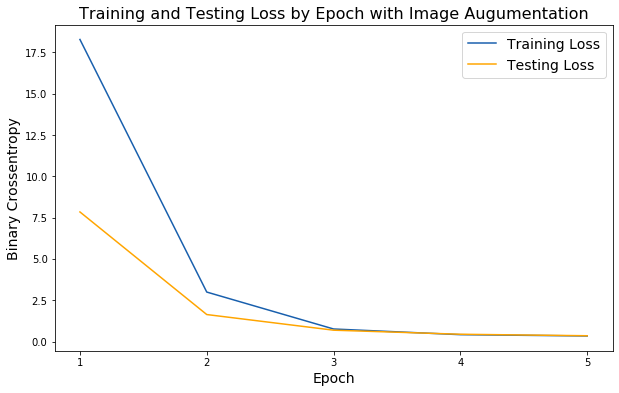

In [40]:


# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(10, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch with Image Augumentation', fontsize = 16)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Binary Crossentropy', fontsize = 14)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 14);

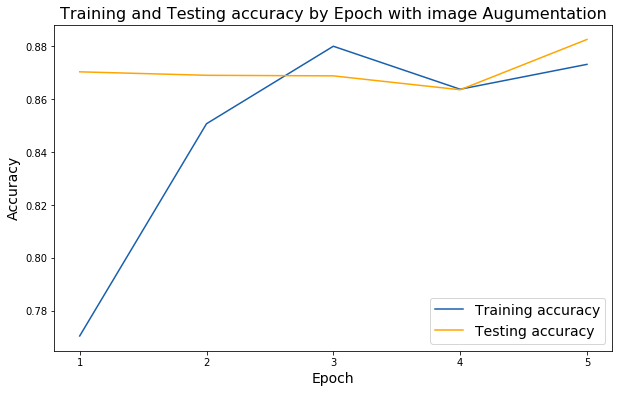

In [42]:

# Check out our train loss and test loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(10, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training accuracy', color='#185fad')
plt.plot(test_loss, label='Testing accuracy', color='orange')

# Set title
plt.title('Training and Testing accuracy by Epoch with image Augumentation', fontsize = 16)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy' , fontsize = 14)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 14);

In [43]:
cnn_score = cnn_model.evaluate(X_test,
                               y_test,
                               verbose=1)

cnn_labels = cnn_model.metrics_names

916/916 [==============================] - 1s 933us/sample - loss: 0.3478 - acc: 0.8825


In [0]:
ynew = cnn_model.predict_classes(X_test)

**Pretrained Model VGG16 with Image Augumentaion** 

In [0]:

base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [54]:

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)
x = Dense(1028, activation='relu')(x)
predictions = Dense(5, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
len(model.layers)

23

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [56]:
for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers:
    print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
global_average_pooling2d_1 True
dense_13 True
dense_14 True
dense_15 True


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback


checkpoint = ModelCheckpoint('/checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

In [0]:
#from tensorflow.keras.optimizers import Adam
#ada = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [0]:
model.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy'])

In [59]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=256),
                        validation_data=(X_test, y_test),
                        epochs=30,
                        verbose=1)

Epoch 1/30
10/11 [==========================>...] - ETA: 2s - loss: 0.5134 - acc: 0.8459Epoch 1/30
916/11 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

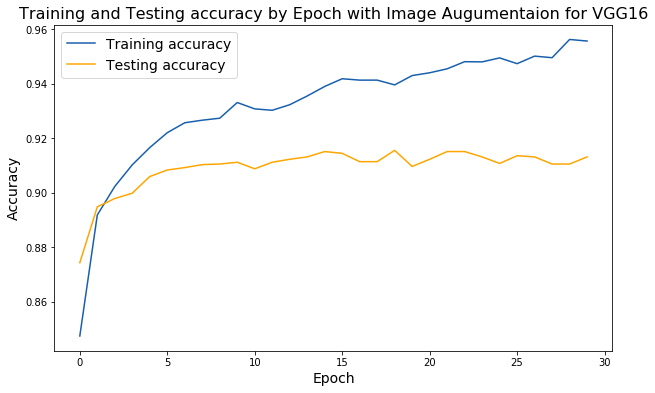

In [62]:

# Check out our train loss and test loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(10, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training accuracy', color='#185fad')
plt.plot(test_loss, label='Testing accuracy', color='orange')

# Set title
plt.title('Training and Testing accuracy by Epoch with Image Augumentaion for VGG16', fontsize = 16)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
#plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 14);

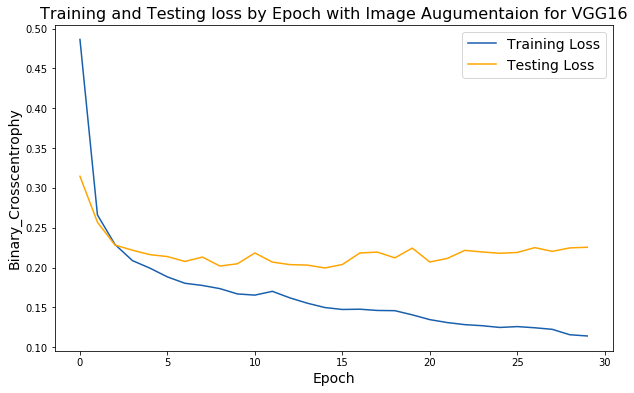

In [64]:

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(10, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing loss by Epoch with Image Augumentaion for VGG16', fontsize = 16)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Binary_Crosscentrophy', fontsize = 14)
#plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 14);


The VGG16 Pretrained model has the accuracy opf 0.91. And this model is used to predict the test images which are the following commands

In [0]:
pred_class= model.predict(photos_test)


In [0]:
#y_photos_test = np.argmax( pred_class ,axis=None,out=None)

y_photos_test = [np.argmax(y, axis=None, out=None) for y in pred_class]

In [0]:
df_pred = pd.DataFrame(labels_test) 

In [0]:
df_pred['classes'] = y_photos_test

In [0]:
my_columns = ["id_code", "diagnosis"]

df_pred.columns = my_columns

df_pred.head()

,id_code,diagnosis
0,afc9e5eb7158,2
1,b9195b82342b,2
2,dff51d618ebd,2
3,eb470f336ee2,2
4,c5c5c97d4404,2


In [0]:
df_test =pd.read_csv('/content/drive/My Drive/Capstone/Data/test.csv')

In [0]:
df_test = df_test.merge(df_pred,how='left')

In [0]:
df_test.to_csv('/content/drive/My Drive/Capstone/Data/sample_submission.csv')

In [0]:
from google.colab import files
files.download('sample_submission.csv')

Sample Image for the filters of the VGG16 in between layers. 

In [0]:
inp = X_test[0]

In [0]:
inp =np.array([inp])

In [0]:
inp.shape

In [0]:
activations= model.predict(inp)

In [0]:
activations.shape[1]

5

**Layer1 : Output**

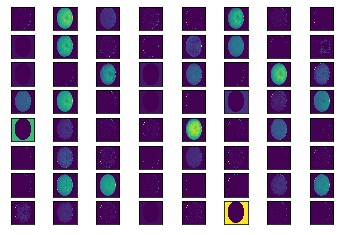

In [68]:
model_l1 = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = model_l1.predict(inp)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[ :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure
	plt.show()

**Layer5 Output**

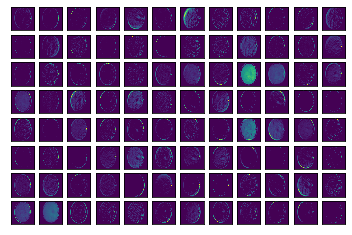

In [83]:
model_l5 = Model(inputs=model.inputs, outputs=model.layers[5].output)
feature_maps = model_l5.predict(inp)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for i in range(8):
		for j in range(12):
			# specify subplot and turn of axis
			ax = plt.subplot(8, 12, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[ :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure
	plt.show()

**ResNet Base Model**

The resnet101 pretrained model is evaluvated , to see if there is any room for improvement in accuracy. But the accuracy was 0.76.

In [84]:

# create the base pre-trained model
base_resnet_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

171450368/171446536 [==============================] - 3s 0us/step


In [85]:

x = base_resnet_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='sigmoid')(x)
model_resnet = Model(inputs=base_resnet_model.input, outputs=predictions)
len(model_resnet.layers)

349

In [86]:
for layer in base_resnet_model.layers:
    layer.trainable = False

for layer in model_resnet.layers:
    print(layer.name,layer.trainable)

input_3 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [0]:
model_resnet.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy'])

In [89]:
history_resnet = model_resnet.fit(datagen.flow(X_train, y_train, batch_size=256),
                        validation_data=(X_test, y_test),
                        epochs=30,
                        verbose=1)

Epoch 1/30
10/11 [==========================>...] - ETA: 3s - loss: 0.3920 - acc: 0.8202Epoch 1/30
916/11 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**Learning transfer from DenseNet with Image Augumentation**





The Dense121 pretrained model is evaluvated , to see if there is any room for improvement in accuracy. But the accuracy was 0.74

In [0]:
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='sigmoid')(x)
model_densenet = Model(inputs=base_model.input, outputs=predictions)
len(model_densenet.layers)

In [108]:
for layer in base_model.layers:
    layer.trainable = False

for layer in model_densenet.layers:
    print(layer.name ,layer.trainable)
  

input_5 False
zero_padding2d_2 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_3 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_co

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
model_densenet.compile(optimizer= Adam(lr=.0001), loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [0]:
BATCH_SIZE = 32

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []
        self.validation_data = (X_test, y_test)

    def on_epoch_end(self, epoch, logs={}):
        #print(self.validation_data)
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_test) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [0]:
model.predict(X_test)

array([[9.99990046e-01, 3.03387642e-05, 6.87837601e-05, 2.11596489e-05,
        8.88109207e-05],
       [1.30662322e-02, 3.61480594e-01, 4.54559982e-01, 1.41799450e-04,
        1.82780623e-03],
       [9.99975204e-01, 4.73037362e-03, 5.75184822e-06, 1.49011612e-07,
        5.66244125e-07],
       ...,
       [4.65623021e-01, 6.07750773e-01, 8.06215703e-02, 1.61290169e-04,
        3.22737098e-02],
       [1.05199724e-01, 9.23617482e-01, 7.13301599e-02, 5.76108694e-04,
        2.88271010e-02],
       [9.99999702e-01, 1.52885914e-05, 2.59280205e-06, 2.05636024e-06,
        7.86781311e-06]], dtype=float32)

In [116]:
kappa_metrics = Metrics()

history_kappa = model_densenet.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[kappa_metrics]
)

Epoch 1/15
916/86 [===============================================================================================================================================================================================================================================================================================================================] - 10s 11ms/sample - loss: 2.0999 - acc: 0.8004
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
86/86 [==============================] - 60s 695ms/step - loss: 0.1943 - acc: 0.9186 - val_loss: 2.2821 - val_acc: 0.8004
Epoch 2/15
916/86 [===============================================================================================================================================================================================================================================================================================================================] - 6s 7ms/sample - loss: 2.1787 - acc: 0.7983
val_kappa: 0.0000
Validation Kappa has impr

**Saving Model**

The VGG16 learning Transfermodel is saved for the deployment

In [0]:
model.save('/content/drive/My Drive/Capstone/model_vgg16.h5')